<a href="https://colab.research.google.com/github/SD325/NASA_Internship_2020/blob/master/NASA_2_Stage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import joblib
import pickle
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Working Directory 
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'

# Load and Split Data

In [3]:
with open(BASE_DIR + 'X_data.pkl', 'rb') as f:
  X = pickle.load(f)
  print(f'Loaded X. {X.shape}')

with open(BASE_DIR + 'y_data.pkl', 'rb') as f:
  y = pickle.load(f)
  print(f'Loaded y. {y.shape}')

Loaded X. (667630, 47)
Loaded y. (667630, 4)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"train: {X_train.shape} {y_train.shape}")
print(f"test: {X_test.shape} {y_test.shape}")

train: (534104, 47) (534104, 4)
test: (133526, 47) (133526, 4)


# SMOTE

In [5]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X_train, y_train)
print(X_sm.shape, y_sm.shape)

(2043776, 47) (2043776, 4)


In [6]:
from collections import Counter
print("original: ", Counter(np.argmax(y_train, axis=1)))
print("SMOTE: ", Counter(np.argmax(y_sm, axis=1)))

original:  Counter({0: 510944, 1: 19090, 2: 2615, 3: 1455})
SMOTE:  Counter({0: 510944, 1: 510944, 3: 510944, 2: 510944})


# Prep Data for Stage 1

In [7]:
'''
Binary Labels:
0 - no precipitation
1 - precipitation
'''
y_train_bin = (y_sm[:, 0] == 0.0).astype(int)
y_test_bin = (y_test[:, 0] == 0.0).astype(int)
print(f"y_train_bin: {y_train_bin.shape}")
print(f"y_test_bin: {y_test_bin.shape}")

y_train_bin: (2043776,)
y_test_bin: (133526,)


In [8]:
print(y_sm)
print("-"* 30)
print(y_train_bin)

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]
------------------------------
[0 0 0 ... 1 1 1]


# Stage 1: Binary Model

In [9]:
# weighted loss function
import keras.backend as K

def get_binary_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def binary_weighted_loss(y_true, y_pred):
        loss = K.mean(-(pos_weights*y_true[:]*K.log(y_pred[:]+epsilon) + neg_weights*(1-y_true[:])*K.log((1-y_pred[:])+epsilon)))
        return loss
    return binary_weighted_loss

# class weights
neg_weights = np.mean(y_train_bin, axis=0)
pos_weights = 1 - neg_weights

Using TensorFlow backend.


In [10]:
# test binary weighted loss
f = get_binary_weighted_loss(pos_weights, neg_weights)
f(y_train_bin, y_train_bin)

<tf.Tensor: shape=(), dtype=float64, numpy=-3.7499998146895145e-08>

## Binary Classification Model

In [11]:
model = keras.models.Sequential([
        layers.InputLayer(input_shape=(47,)),
        layers.Dense(128, activation=tf.nn.relu), 
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(1, activation=tf.nn.sigmoid)
    ])

model.compile(optimizer='adam',
              loss=get_binary_weighted_loss(pos_weights, neg_weights),
              metrics=['accuracy',
                       keras.metrics.TruePositives(name='tp'),
                       keras.metrics.FalsePositives(name='fp'),
                       keras.metrics.TrueNegatives(name='tn'),
                       keras.metrics.FalseNegatives(name='fn')])

In [12]:
history = model.fit(X_sm, y_train_bin, validation_data=(X_test, y_test_bin), epochs=5)

Epoch 1/5
63868/63868 [==============================] - 369s 6ms/step - loss: 0.0432 - accuracy: 0.9636 - tp: 1485870.0000 - fp: 27417.0000 - tn: 483527.0000 - fn: 46962.0000 - val_loss: 0.0931 - val_accuracy: 0.9489 - val_tp: 5581.0000 - val_fp: 6588.0000 - val_tn: 121125.0000 - val_fn: 232.0000
Epoch 2/5
63868/63868 [==============================] - 370s 6ms/step - loss: 0.0320 - accuracy: 0.9767 - tp: 1506748.0000 - fp: 21513.0000 - tn: 489431.0000 - fn: 26084.0000 - val_loss: 0.0738 - val_accuracy: 0.9580 - val_tp: 5480.0000 - val_fp: 5269.0000 - val_tn: 122444.0000 - val_fn: 333.0000
Epoch 3/5
63868/63868 [==============================] - 364s 6ms/step - loss: 0.0285 - accuracy: 0.9802 - tp: 1511747.0000 - fp: 19396.0000 - tn: 491548.0000 - fn: 21085.0000 - val_loss: 0.0860 - val_accuracy: 0.9560 - val_tp: 5504.0000 - val_fp: 5568.0000 - val_tn: 122145.0000 - val_fn: 309.0000
Epoch 4/5
63868/63868 [==============================] - 365s 6ms/step - loss: 0.0267 - accuracy: 0.982

In [13]:
print(y_test_bin.shape)
y_test_bin

(133526,)


array([0, 0, 0, ..., 0, 0, 0])

In [14]:
y_pred_bin = model.predict(X_test)[:, 0]
print(y_pred_bin.shape)
y_pred_bin

(133526,)


array([2.1720667e-14, 8.5969738e-09, 0.0000000e+00, ..., 7.3824125e-21,
       2.4526412e-06, 7.1803381e-04], dtype=float32)

In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

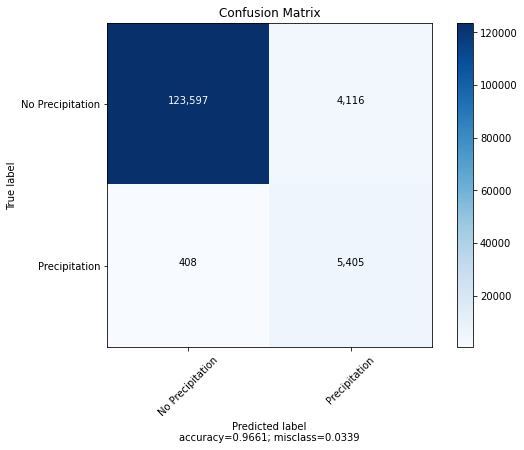

In [16]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_bin, np.round(y_pred_bin))

plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['No Precipitation', 'Precipitation'],
                      title        = "Confusion Matrix")

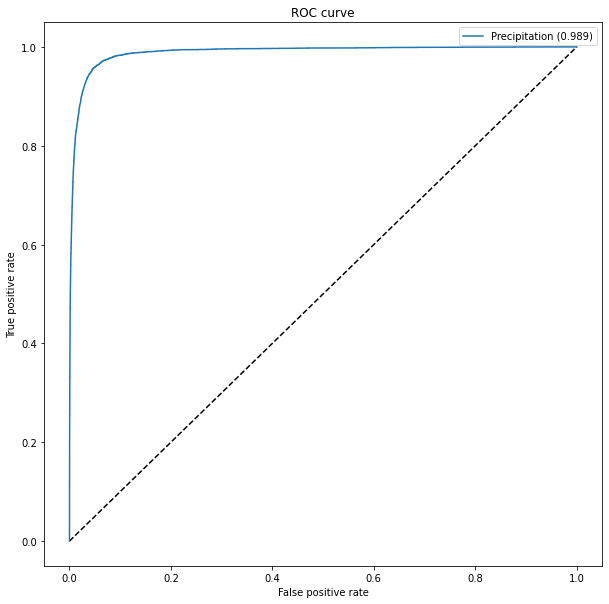

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve

auc_roc = roc_auc_score(y_test_bin, y_pred_bin)
fpr_rf, tpr_rf, _ = roc_curve(y_test_bin, y_pred_bin)
plt.figure(1, figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf,
          label='Precipitation' + " (" + str(round(auc_roc, 3)) + ")")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Prep for Stage 2

In [66]:
print(np.sum(y_train_bin == 1.0))
X_train_multi = X_sm[y_train_bin == 1.0]
y_train_multi = y_sm[y_train_bin == 1.0]# [:, 1:] --> only predict rain types (not 'no precipitation')
print(X_train_multi.shape, y_train_multi.shape)

1532832
(1532832, 47) (1532832, 4)


In [67]:
### don't use this --> use predicted outputs ##########
# print(np.sum(y_test_bin == 1.0))
# X_test_multi = X_test[y_test_bin == 1.0]
# y_test_multi = y_test[y_test_bin == 1.0]
# X_test_multi.shape
#######################################################
print(np.sum(np.round(y_pred_bin) == 1.0))
X_test_multi = X_test[np.round(y_pred_bin) == 1.0]
y_test_multi = y_test[np.round(y_pred_bin) == 1.0]# [:, 1:] --> only predict rain types (not 'no precipitation')
print(X_test_multi.shape, y_test_multi.shape)

9521
(9521, 47) (9521, 4)


In [68]:
y_train_multi

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [69]:
y_test_multi  # contains [0, 0, 0] if use [:, 1:]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

# Stage 2: Multiclass Model

In [70]:
# weighted loss function
import keras.backend as K

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i]*y_true[:, i]*K.log(y_pred[:, i]+epsilon)
                             + neg_weights[i]*(1-y_true[:, i])*K.log((1-y_pred[:, i])+epsilon)))
        return loss
    return weighted_loss

neg_weights = np.mean(y_train_multi, axis=0)
pos_weights = 1 - neg_weights

In [71]:
stage_2 = keras.models.Sequential([
        layers.InputLayer(input_shape=(47,)),
        layers.Dense(128, activation=tf.nn.relu), 
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(4, activation=tf.nn.softmax)
    ])

stage_2.compile(optimizer='adam',
              loss=get_weighted_loss(pos_weights, neg_weights),
              metrics=['accuracy'])

In [72]:
# initialize weights to stage 1 weights
stage_2.layers[0].set_weights(model.layers[0].get_weights())
stage_2.layers[1].set_weights(model.layers[1].get_weights())
stage_2.layers[2].set_weights(model.layers[2].get_weights())

In [73]:
history = model.fit(X_train_multi, y_train_multi, validation_data=(X_test_multi, y_test_multi), epochs=5)

Epoch 1/5
47901/47901 [==============================] - 180s 4ms/step - loss: 0.2133 - accuracy: 0.9180 - val_loss: 8.0806 - val_accuracy: 0.4638
Epoch 2/5
47901/47901 [==============================] - 184s 4ms/step - loss: 0.1151 - accuracy: 0.9590 - val_loss: 8.3294 - val_accuracy: 0.4808
Epoch 3/5
47901/47901 [==============================] - 179s 4ms/step - loss: 0.0836 - accuracy: 0.9708 - val_loss: 8.5098 - val_accuracy: 0.4846
Epoch 4/5
47901/47901 [==============================] - 188s 4ms/step - loss: 0.0666 - accuracy: 0.9771 - val_loss: 8.5109 - val_accuracy: 0.4801
Epoch 5/5
47901/47901 [==============================] - 187s 4ms/step - loss: 0.0564 - accuracy: 0.9813 - val_loss: 8.6786 - val_accuracy: 0.4861


In [75]:
y_pred = model.predict(X_test_multi)

In [74]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

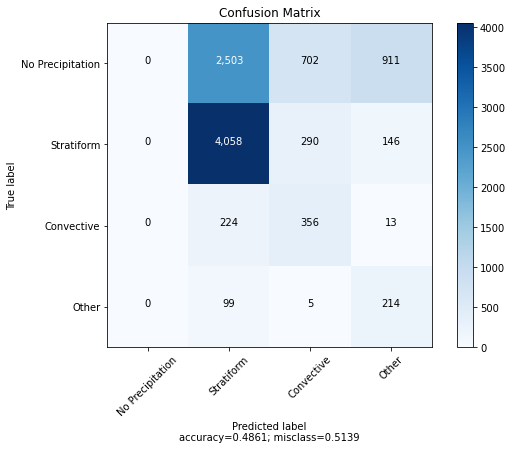

In [76]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(np.argmax(y_test_multi, axis=1), np.argmax(y_pred, axis=1))

plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['No Precipitation', 'Stratiform', 'Convective', 'Other'],
                      title        = "Confusion Matrix")

In [77]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_roc_curve(labels, y_true, y_pred):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = y_true[:, i]
            pred = y_pred[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

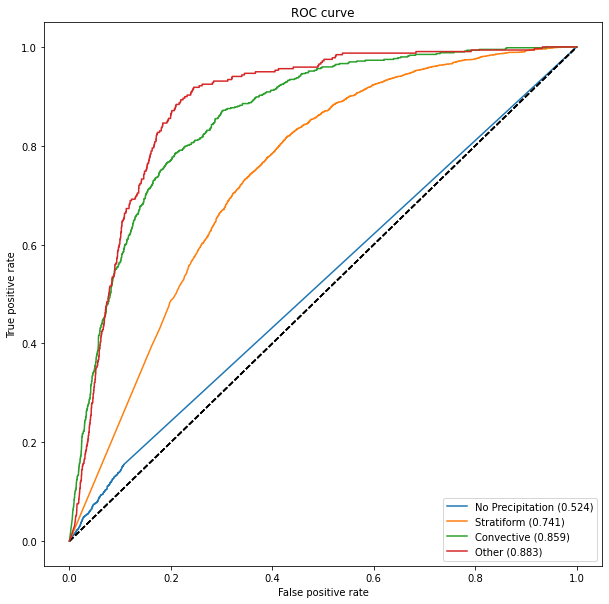

In [78]:
auc_rocs = get_roc_curve(['No Precipitation', 'Stratiform', 'Convective', 'Other'], y_test_multi, y_pred)